# Quick start

Most code is from https://github.com/rubai5/ESS_Game

## This notebook trains a defender agent with PPO

This notebook offers example code on how to train a defender agent on the ESS environment with PPO. Note that for the code to work correctly, you'll need the modified versions of gym and OpenAI baselines installed (we recommend on a virtual environment). 

Links to modified gym/baselines:


https://github.com/rubai5/baselines


https://github.com/rubai5/gym


### Imports

In [1]:
import os, sys
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline 
from datetime import datetime
import pickle

from mpi4py import MPI
import os.path as osp
import gym, logging
import baselines
from baselines import logger
from baselines.ppo1 import pposgd_simple_generalization, mlp_policy
import baselines.common.tf_util as U
from copy import deepcopy
import json
import os

## Game Paramters
The ESS game has a huge number of possible states. The gym environment has some ways of sampling from these states, and here, we set the parameters to mix the distributions as desired

In [2]:
# parameters
name = "ErdosGame-v0"
seed = 101

# game specific parameters
K = 15
potential = 0.9

# sampling probabilities, must sum to 1
unif_prob = 0.0
geo_prob = 1.0
diverse_prob = 0.0
state_unif_prob = 0.0 # can only use if K is small < 10 -- try to use previous methods instead

assert (unif_prob + geo_prob + diverse_prob + state_unif_prob == 1), "probabilites don't sum to 1"

# attacker plays adversarially?
adverse_set_prob = 0.0
disj_supp_prob = 0.5

# high one
high_one_prob = 0.0

# upper limits for start state sampling
geo_high = K - 2
unif_high = max(3, K-3)

# putting into names_and_args argument
names_and_args = {"K" : K, 
                  "potential" : potential, 
                  "unif_prob" : unif_prob, 
                  "geo_prob" : geo_prob,
                   "diverse_prob" : diverse_prob, 
                  "state_unif_prob" : state_unif_prob, 
                  "high_one_prob" : high_one_prob, 
                  "adverse_set_prob" :adverse_set_prob, 
                  "disj_supp_prob" : disj_supp_prob, 
                  "geo_high" : geo_high, 
                  "unif_high" :unif_high }

## Game board

In [4]:
from gym.envs.maithra.erdosgame import ErdosGameEnv

env = ErdosGameEnv(**names_and_args)

Board:  [16363  6564     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
Observation space:  ErdosGame(32,)
Action space:  Discrete(2)
A:  [8182 3282    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
B:  [8181 3282    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
(16,) (16,)


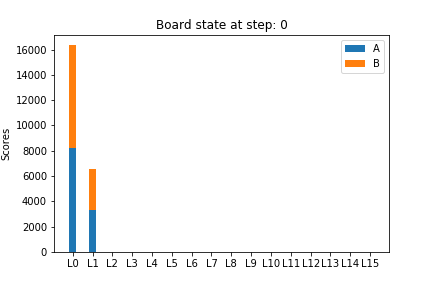

In [19]:
env.reset()
print("Board: ", env.game_state)
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)
print("A: ", env.state[:env.K+1])
print("B: ", env.state[env.K+1:])
env.render()

### Model Paramters

In [3]:
HID_SIZE=300
NUM_HID_LAYERS=2

### Policy Net, Train and Test function

In [4]:
# functions to initialize environment and train model

def policy_fn(name, ob_space, ac_space):
        return mlp_policy.MlpPolicy(name=name, ob_space=ob_space, ac_space=ac_space, 
                                    hid_size=HID_SIZE, num_hid_layers=NUM_HID_LAYERS)
    
def make_policies(ob_space, ac_space, policy_func):
    pi = policy_func("pi", ob_space, ac_space)
    oldpi = policy_func("old_pi", ob_space, ac_space)
    return pi, oldpi

def train(env_train, pi, oldpi, names_and_args, num_timesteps, test_envs):
    #workerseed = seed + 10000 * MPI.COMM_WORLD.Get_rank()
    #set_global_seeds(workerseed)
    
    env_train.reset()
    if test_envs:
        for test_env in test_envs:
            test_env.reset()
    
    #env.seed(workerseed)
    gym.logger.setLevel(logging.WARN)
    # create file handler which logs even debug messages
    fh = logging.FileHandler('spam.log')
    fh.setLevel(logging.DEBUG)
    # create console handler with a higher log level
    ch = logging.StreamHandler()
    ch.setLevel(logging.ERROR)
    # create formatter and add it to the handlers
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    gym.logger.addHandler(fh)
    gym.logger.addHandler(ch)
        

    policy_net, info = pposgd_simple_generalization.learn(env_train, pi, oldpi,
        max_timesteps=num_timesteps,
        timesteps_per_batch=100,
        clip_param=0.2, entcoeff=0.01,
        optim_epochs=4, optim_stepsize=1e-3, optim_batchsize=50,
        gamma=0.99, lam=0.95,
        schedule='linear',
        test_envs=test_envs
    )

    return policy_net, info


def test_policy(num_rounds, policy_net, test_env):
    total_reward = 0.0
    horizon = test_env.observation_space.K*num_rounds # generate around num_rounds draws
    seg_gen = pposgd_simple_generalization.traj_segment_generator(policy_net, test_env, horizon, stochastic=True)
    
    # call generator
    results = seg_gen.__next__()
    mean_reward = np.mean(results["ep_rets"])
    actions = results["ac"]
    labels = results["label"]
    mean_correct_actions = compute_correct_actions(labels, actions)
    return mean_reward, mean_correct_actions

def compute_correct_actions(label, ac):
    count = 0
    idxs = np.all((label == [1,1]), axis=1)
    count += np.sum(idxs)
    new_label = label[np.invert(idxs)]
    new_ac = ac[np.invert(idxs)]
    count += np.sum((new_ac == np.argmax(new_label, axis=1)))
    avg = count/len(label)
    return avg

### A note on sessions
To run most of the baselines code, we need to explicitly state that the session is the default one, i.e. start with
    <code here>
    with sess.as_default():
    </code here>
The code is currently set up for initializing sess = U.single_threaded_session() as a global variable and closing/reseting the graph explicitly to enable restarts, etc. Note that U.reset() must be used along with tf.reset_default_graph()

### Functions to load graphs and sessions

In [5]:
# utilities
def reset_session_and_graph():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    U.reset()
    
def save_session(fp):
    # saves session
    assert fp[-5:] == ".ckpt", "checkpoint name must end with .ckpt"
    saver = tf.train.Saver()
    saver.save(sess, fp)
    
def load_session_and_graph(fp_meta, fp_ckpt):
    saver = tf.train.import_meta_graph(fp_meta)
    saver.restore(sess, fp_ckpt)
    U.load_state(fp_ckpt)

In [31]:
# Warning: this cell can be quite verbose
reset_session_and_graph()
sess = U.single_threaded_session()
num_timesteps = 50000
pposgd_simple_generalization.logger.set_level(0)
n_steps = 20
images = list()

with sess.as_default():
    # Train agent
    env_train =  gym.make(name, **names_and_args)
    pi, oldpi = make_policies(env_train.observation_space, 
                              env_train.action_space, 
                              policy_fn)
    policy_net, info = pposgd_simple_generalization.learn(
        env_train, pi, oldpi,
        max_timesteps=num_timesteps,
        timesteps_per_batch=100,
        clip_param=0.2, entcoeff=0.01,
        optim_epochs=4, optim_stepsize=1e-3, optim_batchsize=50,
        gamma=0.99, lam=0.95,
        schedule='linear',
        test_envs=list(),
        callback = None
    )
    
    # Test agent
    env = gym.make(name, **names_and_args)
    pi = policy_net
    num_rounds = 2
    stochastic = True
    horizon = env.observation_space.K * num_rounds
    t = 0
    ac = env.action_space.sample() # not used, just so we have the datatype
    new = True # marks if we're on first timestep of an episode
    ob = env.reset()
    label = env.env.labels()

    cur_ep_ret = 0 # return in current episode
    cur_ep_len = 0 # len of current episode
    ep_rets = list() # returns of completed episodes in this segment
    ep_lens = list() # lengths of ...

    # Initialize history arrays
    labels = np.array([label for _ in range(horizon)])
    obs = np.array([ob for _ in range(horizon)])
    rews = np.zeros(horizon, 'float32')
    vpreds = np.zeros(horizon, 'float32')
    news = np.zeros(horizon, 'int32')
    acs = np.array([ac for _ in range(horizon)])
    prevacs = acs.copy()

    for _ in range(n_steps):
        prevac = ac
        ac, vpred = pi.act(stochastic, ob)
        # Slight weirdness here because we need value function at time T
        # before returning segment [0, T-1] so we get the correct
        # terminal value
        if t > 0 and t % horizon == 0:
            m = {"label" : labels, "ob" : obs, "rew" : rews, "vpred" : vpreds, "new" : news,
                    "ac" : acs, "prevac" : prevacs, "nextvpred": vpred * (1 - new),
                    "ep_rets" : ep_rets, "ep_lens" : ep_lens}
            # Be careful!!! if you change the downstream algorithm to aggregate
            # several of these batches, then be sure to do a deepcopy
            ep_rets = list()
            ep_lens = list()
        i = t % horizon
        labels[i] = label
        obs[i] = ob
        vpreds[i] = vpred
        news[i] = new
        acs[i] = ac
        prevacs[i] = prevac

        ob, rew, new, _ = env.step(ac)
        images.append(env.env.render())
        label = env.env.labels()
        rews[i] = rew

        cur_ep_ret += rew
        cur_ep_len += 1

        if new:
            ep_rets.append(cur_ep_ret)
            ep_lens.append(cur_ep_len)
            cur_ep_ret = 0
            cur_ep_len = 0
            ob = env.reset()
            label = env.env.labels()
        t += 1

[2020-03-06 21:44:16,052] Making new env: ErdosGame-v0


********** Iteration 0 ************
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
-0.00052640215 | -0.0069296993 |      0.682351 | 0.00018205993 |     0.6929699
 -0.021408424 | -0.0069104536 |     0.3740214 |  0.0021307976 |     0.6910454
 -0.042678107 | -0.0068537947 |    0.28432044 |   0.007873091 |     0.6853795
 -0.051055953 |  -0.006744263 |    0.27829558 |   0.019232899 |     0.6744263
Evaluating losses...
   -0.0561567 |   -0.00666754 |      0.243417 |     0.0273324 |      0.666754
------------------------------
| EpLenMean       | 15       |
| EpRewMean       | -0.667   |
| EpThisIter      | 6        |
| EpisodesSoFar   | 6        |
| TimeElapsed     | 0.496    |
| TimestepsSoFar  | 90       |
| ev_tdlam_before | -0.646   |
| loss_ent        | 0.667    |
| loss_kl         | 0.0273   |
| loss_pol_entpen | -0.00667 |
| loss_pol_surr   | -0.0562  |
| loss_vf_loss    | 0.243    |
------------------------------
********** Iteration 1 ***

[2020-03-06 21:45:58,347] Making new env: ErdosGame-v0


In [35]:
for i, img in enumerate(images):
    img.save("{}.png".format(i))

Train network over a number of repeats for a grid of parameters
For the real grid evaluation go check ```grid_script.py```

In [ ]:
# Warning: this cell can be quite verbose

repeats = 3
SAVE_FP = "./tmp/models"
os.makedirs(SAVE_FP, exist_ok=True)

from collections import defaultdict

results = defaultdict(lambda: defaultdict(lambda: dict()))

from tqdm import tqdm
test_num_rounds = 100
K = 10
potential = .95

for adv_prob in tqdm(np.linspace(0, 1 , 20+1)):
    names_and_args["K"] = K
    names_and_args["geo_high"] = K-2
    names_and_args["unif_high"] = max(3, K-3)
    names_and_args["potential"] = potential
    rewards = list()
    test_rewards = list()
    for rep in range(repeats):
        reset_session_and_graph()
        sess = U.single_threaded_session()
        with sess.as_default():
            # Make env
            erdos_env = gym.make(name, **names_and_args)
            # Make agent
            pi, oldpi = make_policies(erdos_env.observation_space, 
                                        erdos_env.action_space, 
                                        policy_fn) 
            # Train agent               
            pi, info = train(erdos_env, pi, oldpi, 
                                names_and_args, 
                                num_timesteps=50000, 
                                test_envs=list())
            rewards.append(info["rewards"])

            # Test agent
            for test_env_adv_prob in tqdm(np.linspace(0, 1 , 20+1)):
                results[adv_prob][test_env_adv_prob][rep] = \
                test_policy(test_num_rounds, pi, test_env)
            with open("results.json", "r") as file:
                file.write(json.dumps(results))

            # Save model
            model_fp = "{}model_K{}_potential{}_rep{}.ckpt".format(
                SAVE_FP, K, potential, rep)
            save_session(model_fp)

    # Save results
    with open(SAVE_FP+"rewards_K%02d_potential%f.p"%(K, potential), "wb") as f:
        pickle.dump(rewards, f)